# Assignment for Big Data and AI:
# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

### Submitted by Dennis Linnert (346283)

------------------------------------------------------------------------------------------------------------------------------

## Implementation

Algorithm Code written in accordance with Pseudo-Code in the provided Exam-Paper (Ester et al., 1996).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Main function for algorithm
def dbscan(set_of_points, eps, min_pts):
    # Sets cluster labels to unclassified (-1) for all points
    cluster_labels = np.full(shape=set_of_points.shape[0], fill_value=-1)

    # Starts with cluster_id 0
    cluster_id = 0

    for i in range(set_of_points.shape[0]):
        # For every unclassified point, tries to expand cluster
        if cluster_labels[i] == -1:
            if expand_cluster(set_of_points, cluster_labels, i, cluster_id, eps, min_pts):
                # Moves to next cluster if expand_cluster returns True
                cluster_id += 1

    return cluster_labels

In [3]:
def expand_cluster(set_of_points, cluster_labels, point_idx, cluster_id, eps, min_pts):
    # Finds the points in eps-radius neighborhood (=seeds)
    seeds = region_query(set_of_points, point_idx, eps)
    
    if len(seeds) < min_pts:
        # Point is noise (-2) if less seeds than min_pts hyperparameter
        cluster_labels[point_idx] = -2 
        return False
    else:
        cluster_labels[seeds] = cluster_id

        # starting point already processed -> removed from seeds
        seeds = seeds[seeds != point_idx]

        # For each 'neighbor', finds eps-radius neighbors
        while seeds.size > 0:
            current_point = seeds[0]
            results = region_query(set_of_points, current_point, eps)

            if len(results) >= min_pts:
                # Only keeps not yet classified points
                results = results[cluster_labels[results] == -1]
                # Add new points
                seeds = np.append(seeds, results)

            # Updates cluster label for current point
            if cluster_labels[current_point] == -1 or cluster_labels[current_point] == -2:
                cluster_labels[current_point] = cluster_id

            seeds = seeds[seeds != current_point]

        return True

In [4]:
def region_query(set_of_points, point_idx, eps):
    # euclidean distance (Faußer, 2023)
    distances = np.sqrt(np.sum((set_of_points - set_of_points[point_idx])**2, axis=1))
    # Returns indices of points where distance is less than/equal to eps
    return np.where(distances <= eps)[0]

------------------------------------------------------------------------------------------------------------------------------

## Demonstration

### Data Source: 

As DBSCAN is a density-based clustering algorithm I used a small, fictional dataset to check for performance, followed by a real-world, spatial dataset as recommended by Ester et al. (1996). 


------------------------------------------------------------------------------------------------------------------------------

### Demonstration #1
Moons dataset: https://www.kaggle.com/datasets/berkayalan/sklearn-moons-data-set. The Dataset contains X1/X2 values of two 'half-moons', which demonstrate the power of density-based clustering algorithms when applied to clusters with arbitrary shape.

In [5]:
df = pd.read_csv('data/cluster_moons.csv')

# Converts df to Numpy array
set_of_points = df[['X1', 'X2']].values

### Evaluation of Hyperparameters:

* __Minimum Number of Points in eps-neighborhood (min_pts)__ required to classify point as core point: This parameter is set to 4, as suggested in the paper when using two-dimenstional data (Ester et al., 1996).
     - Larger min_pts = fewer, more dense clusters and increase of noise classification
     - Smaller min_pts =  more, less dense clusters<br><br>
     
* __Eps $ε$__: Radius of 'Neighborhood' around a point
     - Higher $ε$ = larger radius, potentially merges nearby clusters into larger single cluster
     - Lower $ε$ = smaller radius, finer clustering and increase of noise classification

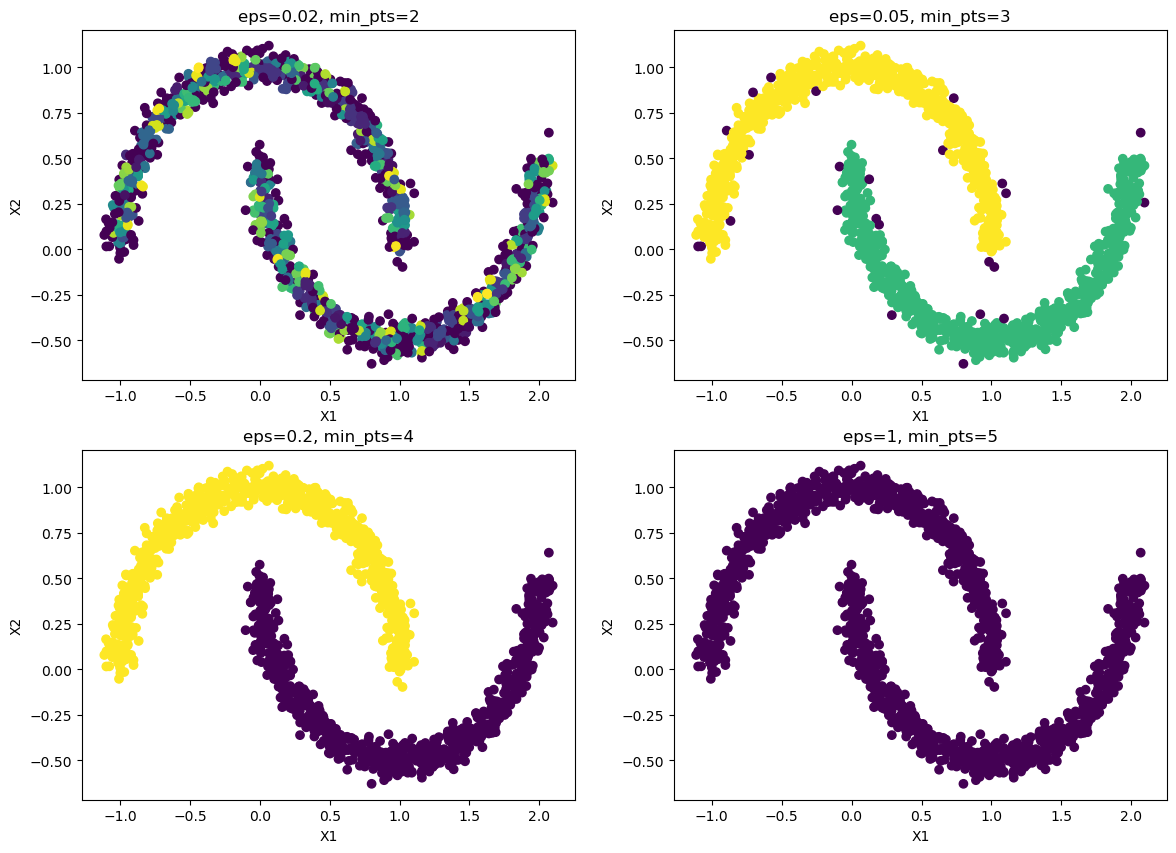

In [6]:
# Different hyperparameter combinations for visual comparison (more multidimensional --> gridsearch)
parameter_combinations = [
    {'eps': 0.02, 'min_pts': 2},
    {'eps': 0.05, 'min_pts': 3},
    {'eps': 0.2, 'min_pts': 4}, # Visually best combination
    {'eps': 1, 'min_pts': 5},
]

# Creates subplots for comparison of combinations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, parameters in enumerate(parameter_combinations):
    eps = parameters['eps']
    min_pts = parameters['min_pts']
    row = i // 2
    col = i % 2

    cluster_labels = dbscan(set_of_points, eps, min_pts)

    ax = axes[row, col]
    ax.scatter(set_of_points[:, 0], set_of_points[:, 1], c=cluster_labels, cmap='viridis')
    ax.set_title(f'eps={eps}, min_pts={min_pts}')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

plt.show()

### Determining optimal hyperparameters: 

* To determine the optimal hyperparameter __Eps $ε$__: In accordance with Ester et al. (1996), the kth nearest neighbor ('elbow method') plot is used, where the y-axis location (distance to 4th nearest neighbor) of the 'elbow' indicates a good separation point between high-density and low-density areas. <br><br>

* For two-dimensional data the hyperparameter __min_pts__ is set to 4, based on the Heuristic by Ester et al. (1996) that determines 4 as the optimal parameter, as the k-dist graphs for k>4 do not significantly differ from the 4-dist graph and, furthermore, they need considerably more computation. 

#### Therefore, the 4-th nearest neighbor method is used to determine eps based on min_pts  = 4. 

In [7]:
# Calculates the distance to the k-th nearest neighbor for each point (with k = min_pts = 4)

min_pts = 4 # As suggested by Ester et al. (1996)

def calculate_kth_distances(points, k):
    kth_distances = []
    for point in points:
        # Euclidean distance
        distances = np.sqrt(np.sum((points - point) ** 2, axis=1))
        sorted_distances = np.sort(distances)
        # Takes the k-th nearest, but not the point itself (k+1)
        kth_distances.append(sorted_distances[k+1])
    return kth_distances

kth_distances = calculate_kth_distances(set_of_points, min_pts)
kth_distances_sorted_desc = np.sort(kth_distances)[::-1]  # Sorts in descending order

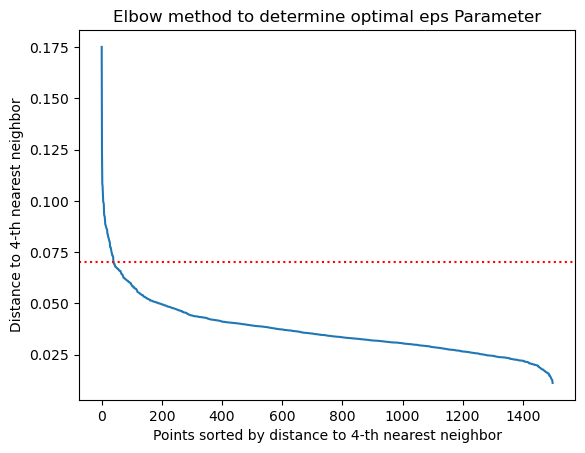

In [8]:
# Plots the 4-th nearest distances
plt.plot(kth_distances_sorted_desc)
plt.title('Elbow method to determine optimal eps Parameter')
plt.ylabel('Distance to {}-th nearest neighbor'.format(min_pts))
plt.axhline(y = 0.07, color = 'r', linestyle = 'dotted') 
plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(min_pts))
plt.show()

'Elbow' located visually, similar to our lecture about clustering (Cluster Validation with elbow-criterion on SSE, Faußer 2023)

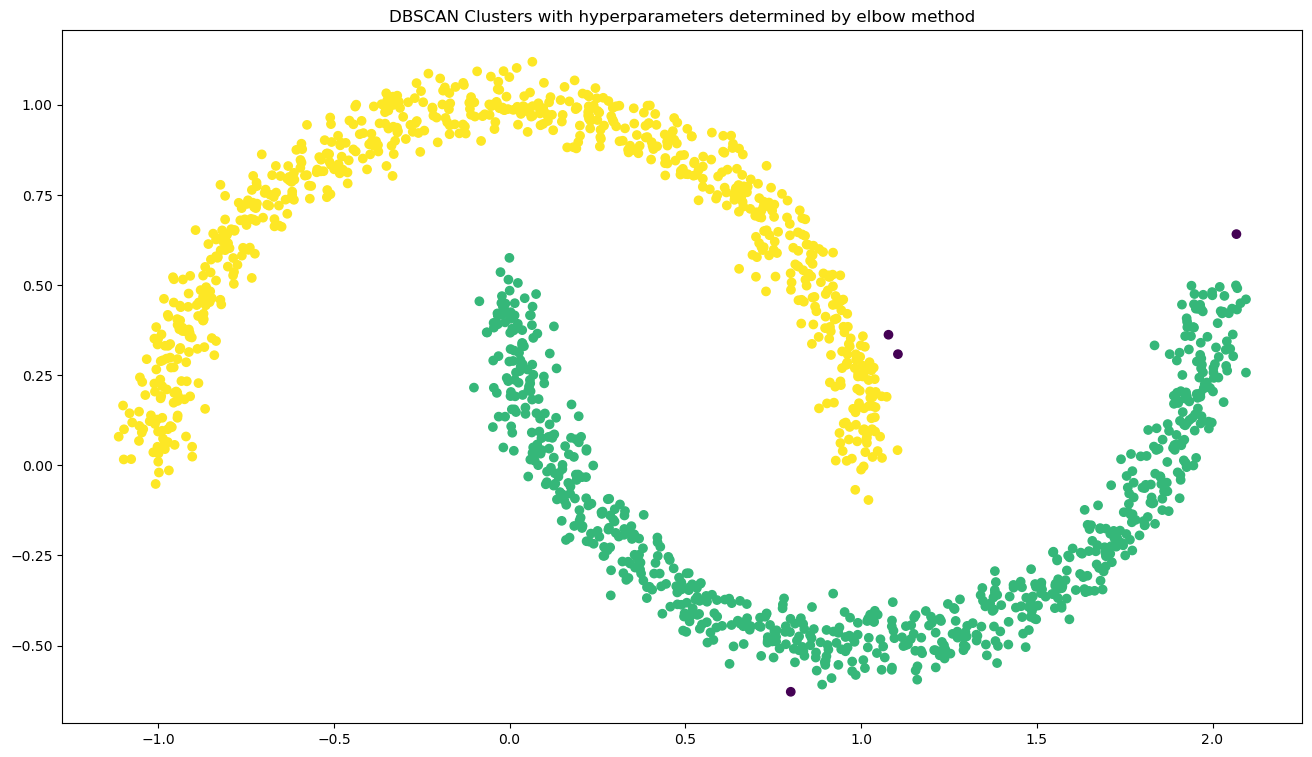

In [9]:
# Parameters according to the elbow method
eps = 0.07
min_pts = 4

cluster_labels = dbscan(set_of_points, eps, min_pts)

plt.figure(figsize=(16,9))
plt.title('DBSCAN Clusters with hyperparameters determined by elbow method')
plt.scatter(set_of_points[:, 0], set_of_points[:, 1], c=cluster_labels)
plt.show()

------------------------------------------------------------------------------------------------------------------------------

### Demonstration #2
Kaggle dataset: https://www.kaggle.com/datasets/adityaramachandran27/world-air-quality-index-by-city-and-coordinates. The Dataset contains latitude/longitude values of 16 695 cities in the world. The goal of this dataset is a comparison of Air Qualities - however, it was used mainly to acquire geodata of cities in the world, as I want to apply the algorithm to two-dimensional data for visual evaluation.

In [10]:
df_cities = pd.read_csv('data/AQI and Lat Long of Countries.csv')
set_of_points_cities = df_cities[['lng', 'lat']].values

In [11]:
# Calculates the distance to the k-th nearest neighbor for each point (with k = min_pts = 4)

min_pts_cities = 4

kth_distances_cities = calculate_kth_distances(set_of_points_cities, min_pts_cities)
kth_distances_sorted_desc_cities = np.sort(kth_distances_cities)[::-1]  # Sorts in descending order

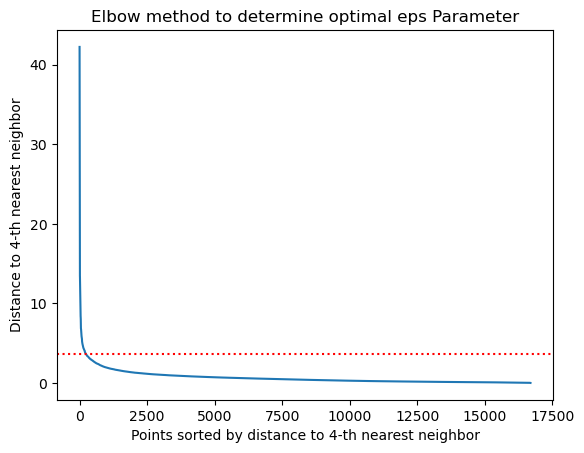

In [12]:
# Plots the 4-th nearest distances
plt.plot(kth_distances_sorted_desc_cities)
plt.title('Elbow method to determine optimal eps Parameter')
plt.ylabel('Distance to {}-th nearest neighbor'.format(min_pts_cities))
plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(min_pts_cities))
plt.axhline(y = 3.6, color = 'r', linestyle = 'dotted') 
plt.show()

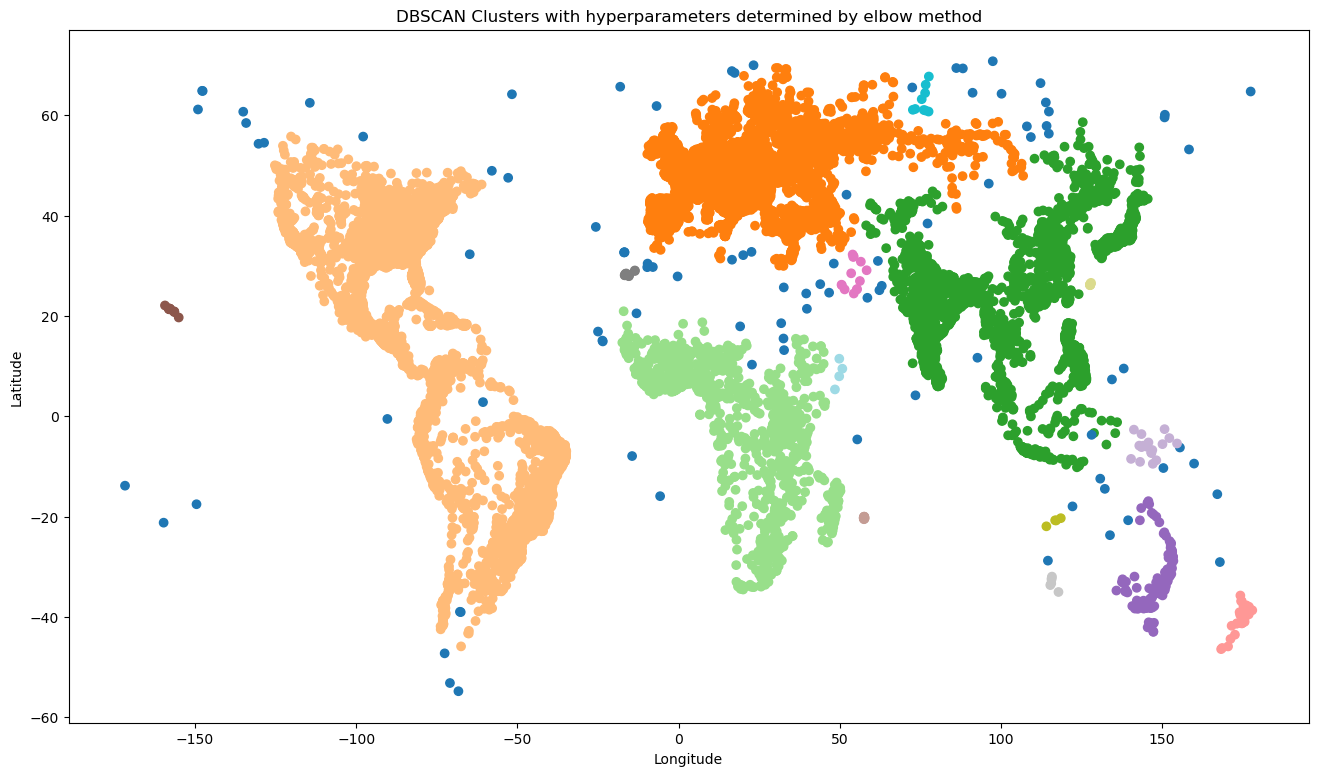

In [13]:
# Sets the parameter
eps_cities = 3.6

cluster_labels_cities = dbscan(set_of_points_cities, eps_cities, min_pts_cities)

plt.figure(figsize=(16,9))
plt.title('DBSCAN Clusters with hyperparameters determined by elbow method')
plt.scatter(set_of_points_cities[:, 0], set_of_points_cities[:, 1], c=cluster_labels_cities, cmap = 'tab20')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

The visualisation shows well separated clusters approximating the Continents/Islands of the World (especially Africa/Americas/Eurasia/South-East Asia and the separation of Japan or New Zealand). Therefore, the determined parameters seem to have found a good balance. 

------------------------------------------------------------------------------------------------------------------------------

## References:

Ester, M., Kriegel, H-P., Sander, J., Xiaowei, X. (1996). A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise. KDD, 96, 226-231.

Faußer, S. (2023). Lecture on Big Data and Artificial Intelligence. University of Applied Sciences Neu-Ulm. Winter term 2023/24.
